# **Fish Classification**

1. Importing The Modules


In [1]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


2. Loading The Fish Data

In [2]:
direc = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head(10)

,FilePaths,Labels
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Striped Red Mullet
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat
5,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
6,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
7,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
8,../input/a-large-scale-fish-dataset/Fish_Datas...,Shrimp
9,../input/a-large-scale-fish-dataset/Fish_Datas...,Shrimp


2.a. Showing First 25 Images

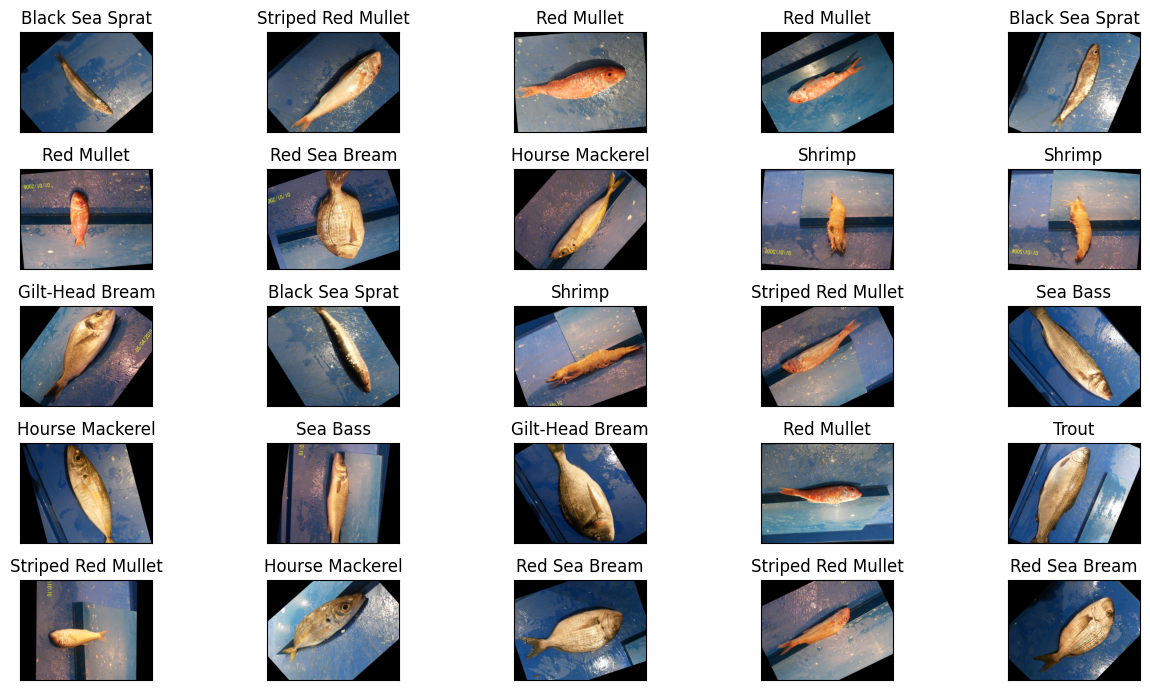

In [3]:
# Showing First 25 Images 
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=5, ncols=5,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

2. b. Shape of DataFrame

In [4]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


2. c. Types of Fishes

In [5]:
img_df['Labels'].value_counts(ascending=True)


Labels
Black Sea Sprat       1000
Striped Red Mullet    1000
Red Mullet            1000
Red Sea Bream         1000
Hourse Mackerel       1000
Shrimp                1000
Gilt-Head Bream       1000
Sea Bass              1000
Trout                 1000
Name: count, dtype: int64

2. d. Graph of the Image Counts

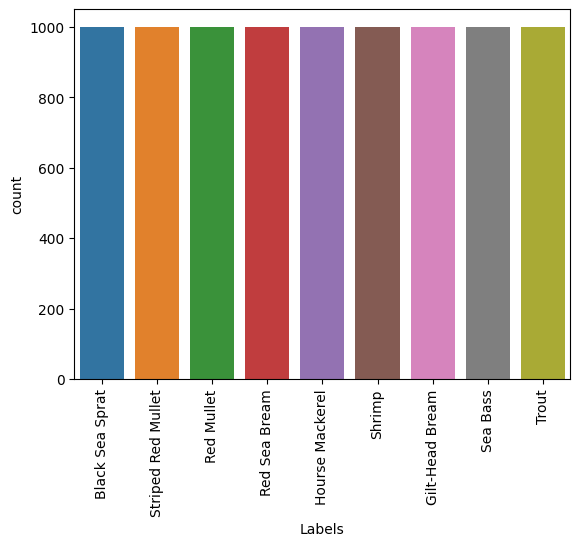

In [6]:
import seaborn as sns
sns.countplot(x="Labels", data = img_df )
plt.xticks(rotation = 90)
plt.show()

3. Models

3. a. Splitting the Data

In [7]:
# Synchronize img_df and Labels datasets
# Get as many labels as the number of images in img_df
Labels = Labels[:len(img_df)]

# Defining augmentation settings using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,            # Rotate images by 20 degrees
    width_shift_range=0.2,        # Horizontal scrolling
    height_shift_range=0.2,       # Vertical scrolling
    shear_range=0.2,              # Shift transform
    zoom_range=0.2,               # Zoom
    horizontal_flip=True,         # Horizontal flip
    fill_mode='nearest'           # Use nearest pixel to fill gaps
)

# Increasing data with Augmentation operation
if len(img_df) < len(Labels):
    diff = len(Labels) - len(img_df)
    
    # Creating new data with Augmentation
    augmented_images = []
    augmented_labels = []
    
    for x_batch, y_batch in datagen.flow(img_df, Labels, batch_size=diff):
        augmented_images.append(x_batch)
        augmented_labels.append(y_batch)
        if len(augmented_images) >= diff:
            break
    
    # Adding new data to existing dataset
    img_df = np.concatenate([img_df, np.array(augmented_images).reshape(diff, *img_df.shape[1:])])
    Labels = np.concatenate([Labels, np.array(augmented_labels).reshape(diff)])

# Check the new dimensions of the datasets
print(f'Updated img_df size: {len(img_df)}')
print(f'Updated Labels size: {len(Labels)}')

# Adjust data rates
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15

# Splitting the dataset into training and temporary (test+validation) sets
x_train, x_temp, y_train, y_temp = train_test_split(img_df, Labels, test_size=1 - train_ratio, random_state=42)

# Split the temporary set into test and validation sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

# Checking the size of datasets
print(f'Shape of Training Data : {x_train.shape}')
print(f'Shape of Validation Data : {x_val.shape}')
print(f'Shape of Testing Data : {x_test.shape}')


Updated img_df size: 9000
Updated Labels size: 9000
Shape of Training Data : (6750, 2)
Shape of Validation Data : (900, 2)
Shape of Testing Data : (1350, 2)


3. b. Augmenating the Data

In [8]:
# Initialize image data generator
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Set target image size
img_size=(224, 224)    

# Create data generators for training, testing, and validation
x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


3. c. Define and Compile the Model

In [9]:
# Define the fully connected model
fc_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Ensure input_shape is correctly specified
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation="softmax")  # Adjust the number of classes as needed
])

# Compile the model with optimizer, loss function, and metrics
fc_model.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3. d. Training the Model

In [10]:
# Train the Model
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

mo_fit = fc_model.fit(x_train, 
                      validation_data=x_val, 
                      epochs=10, 
                      callbacks=[Callback])

# Making predictions on test data
y_pred = fc_model.predict(x_test)
# Get the class with the highest probability
y_pred_classes = tf.argmax(y_pred, axis=1)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


211/211 ━━━━━━━━━━━━━━━━━━━━ 150s 683ms/step - accuracy: 0.3481 - loss: 1.7618 - val_accuracy: 0.6478 - val_loss: 0.9907
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 117s 544ms/step - accuracy: 0.6447 - loss: 0.9800 - val_accuracy: 0.7767 - val_loss: 0.6731
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 118s 545ms/step - accuracy: 0.7715 - loss: 0.6586 - val_accuracy: 0.8367 - val_loss: 0.5217
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 141s 541ms/step - accuracy: 0.8416 - loss: 0.4815 - val_accuracy: 0.8644 - val_loss: 0.4008
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 117s 541ms/step - accuracy: 0.8838 - loss: 0.3412 - val_accuracy: 0.9111 - val_loss: 0.2587
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 118s 546ms/step - accuracy: 0.9171 - loss: 0.2517 - val_accuracy: 0.9256 - val_loss: 0.2351
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 117s 542ms/step - accuracy: 0.9261 - loss: 0.2174 - val_accuracy: 0.9367 - val_loss: 0.1952
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 117s 542ms/step - accuracy: 0.9442 - loss: 0.16

3. e. Model Summary

In [11]:
print('Model summary :')
print()
fc_model.summary()

Model summary :



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,856,157 (220.70 MB)

 Trainable params: 19,285,385 (73.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,570,772 (147.14 MB)

3. f. Model Accuracy and Validation Performance

In [12]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 377ms/step - accuracy: 0.9286 - loss: 0.2446
Test accuracy is :  92.66666769981384 %


3. g. Retrieve training and validation metrics from the training history

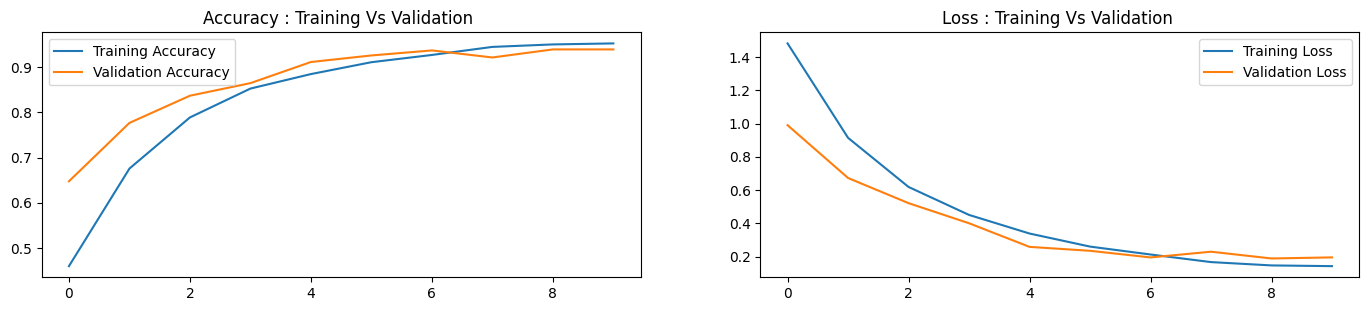

In [13]:
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']

plt.figure(figsize=(17, 7))
# Plot training vs validation accuracy
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')

# Plot training vs validation loss
plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')

plt.show()

In [14]:
print("Accuracy shape:", np.shape(accuracy))
print("Loss shape:", np.shape(loss))
print("Validation Loss shape:", np.shape(validation_loss))
print("Validation Accuracy shape:", np.shape(validation_accuracy))


Accuracy shape: (10,)
Loss shape: (10,)
Validation Loss shape: (10,)
Validation Accuracy shape: (10,)


3. h. Model Testing: Prediction versus Actual

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


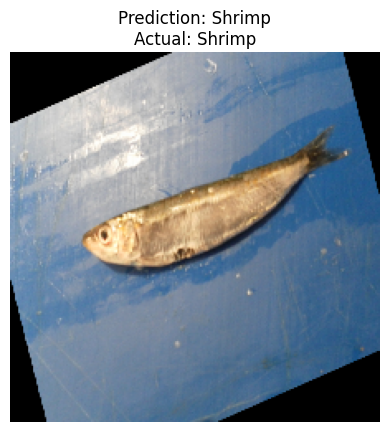

In [15]:
# Load and preprocess the image
img_path = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00014.png' 
img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0) 
img_array /= 255.0  

# Make predictions using the trained model
predictions = fc_model.predict(img_array)  
predicted_class = np.argmax(predictions, axis=1)[0] 

# Define class names for the predictions
class_names = [
    'Black Sea Sprat',
    'Gilt-Head Bream',
    'Horse Mackerel',
    'Red Mullet',
    'Red Sea Bream',
    'Sea Bass',
    'Shrimp',
    'Striped Red Mullet',
    'Trout'
]
true_class_index = 6  # True class index for the image

# Display the image with prediction and actual class
plt.imshow(img) 
plt.title(f'Prediction: {class_names[predicted_class]}\nActual: {class_names[true_class_index]}')
plt.axis('off') 
plt.show() 